<a href="https://colab.research.google.com/github/daniela1409/SO-Lab3-20241/blob/main/Informe_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFORME: PARALELIZACIÓN DE LA FUNCIÓN SAXPY

## SAXPY

La función SAXPY (single-precision A*X plus Y) es una función básica en el álgebra lineal. Esta función es usada recurrentemente para el desarrollo de métodos numéricos, en el procesamiento de señales, etc.

La función saxpy (simulación) desarrolla la multiplicación de un valor escalar
 por un vector
, luego el resultado se suma a un vector
, el resultado usualmente es almacenado nuevamente en el vector
, de esta manera la formulación es la siguiente:

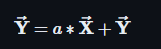

En el codigo presentado en este laboratorio (saxpy.c), vamos a implementar una función saxpy iterativa, con el fin de obtener un tiempo de ejcución adecuado para el desarrollo de este ejercicio usando diferentes numeros de hilos:1, 2, 4 y 8

## Código de la solución (No correr)

In [ ]:
/**
 * @defgroup   SAXPY saxpy
 *
 * @brief      This file implements an iterative saxpy operation
 *
 * @param[in] <-p> {vector size}
 * @param[in] <-s> {seed}
 * @param[in] <-n> {number of threads to create}
 * @param[in] <-i> {maximum itertions}
 *
 * @author     Danny Munera
 * @date       2020
 */

#include <stdio.h>
#include <unistd.h>
#include <stdlib.h>
#include <assert.h>
#include <sys/time.h>
#include <pthread.h>

// Estructura para los argumentos del hilo
struct ThreadArgs {
    double *X;
    double *Y;
    double a;
    int p;
    int max_iters;
    int thread_id;
    double *Y_avgs;
	int n_threads;
};

// Función que ejecutará cada hilo
/**Cada hilo debe procesar aproximadamente la mitad de los elementos del vector Y.
 Por lo tanto, se divide el trabajo dividiendo el rango del bucle iterativo entre los dos hilos.*/
void *saxpy_thread(void *args) {
    struct ThreadArgs *thread_args = (struct ThreadArgs *)args;
    int p = thread_args->p;
    int max_iters = thread_args->max_iters;
    double *X = thread_args->X;
    double *Y = thread_args->Y;
    double a = thread_args->a;
    double *Y_avgs = thread_args->Y_avgs;
    int thread_id = thread_args->thread_id;
	int n_threads = thread_args->n_threads;

	int start_index, end_index;

    // Dividir el trabajo en 2 hilos
	if(n_threads==2){
		start_index = (thread_id == 0) ? 0 : p / 2;
    	end_index = (thread_id == 0) ? p / 2 : p;
	}else if(n_threads==4){
		start_index = (thread_id == 0) ? 0 : p / 4 * thread_id;
		end_index = (thread_id == 3) ? p : p / 4 * (thread_id + 1);
	}else if(n_threads==8){
		start_index = (thread_id == 0) ? 0 : p / 8 * thread_id;
		end_index = (thread_id == 7) ? p : p / 8 * (thread_id + 1);
	}else{
		start_index=0;
		end_index=p;
	}

	//si thread_id es igual a 0 (es decir, es el primer hilo), entonces start_index será 0, entonces este hilo comenzará desde el principio del vector.
	//Si thread_id no es 0 (es decir, es el segundo hilo), entonces start_index será p / 2, entonces este hilo comenzará desde la mitad del vector.

	//Dividir el trabajo en 4 hilos
	/*int start_index = (thread_id == 0) ? 0 : p / 4 * thread_id;
	int end_index = (thread_id == 3) ? p : p / 4 * (thread_id + 1);*/

	//Dividir el trabajo en 8 hilos
	/**/

	//printf("El hilo %d comienza en %d y termina en %d", thread_id, start_index, end_index);
    // Realizar operación SAXPY iterativa
    for (int it = 0; it < max_iters; it++) {
        for (int i = start_index; i < end_index; i++) {
            Y[i] = Y[i] + a * X[i];
            Y_avgs[it + thread_id * max_iters] += Y[i];
        }
    }

    return NULL;
}

int main(int argc, char* argv[]){
	// Variables to obtain command line parameters
	unsigned int seed = 1;
  	int p = 10000000;
  	int n_threads = atoi(argv[1]);
  	int max_iters = 1000;
  	// Variables to perform SAXPY operation
	double* X;
	double a;
	double* Y;
	double* Y_avgs;
	int i;
	// Variables to get execution time
	struct timeval t_start, t_end;
	double exec_time;

	// Getting input values
	//int opt;
	/*while((opt = getopt(argc, argv, ":p:s:n:i:")) != -1){
		switch(opt){
			case 'p':
			printf("vector size: %s\n", optarg);
			p = strtol(optarg, NULL, 10);
			assert(p > 0 && p <= 2147483647);
			break;
			case 's':
			printf("seed: %s\n", optarg);
			seed = strtol(optarg, NULL, 10);
			break;
			case 'n':
			printf("threads number: %s\n", optarg);
			n_threads = strtol(optarg, NULL, 10);
			break;
			case 'i':
			printf("max. iterations: %s\n", optarg);
			max_iters = strtol(optarg, NULL, 10);
			break;
			case ':':
			printf("option -%c needs a value\n", optopt);
			break;
			case '?':
			fprintf(stderr, "Usage: %s [-p <vector size>] [-s <seed>] [-n <threads number>] [-i <maximum itertions>]\n", argv[0]);
			exit(EXIT_FAILURE);
		}
	}  */
	srand(seed);

	printf("p = %d, seed = %d, n_threads = %d, max_iters = %d\n", \
	 p, seed, n_threads, max_iters);

	// initializing data
	X = (double*) malloc(sizeof(double) * p);
	Y = (double*) malloc(sizeof(double) * p);
	//Y_avgs = (double*) malloc(sizeof(double) * max_iters);
	Y_avgs = (double*) calloc(sizeof(double), max_iters * n_threads); // Inicializar todos los elementos a 0

	for(i = 0; i < p; i++){
		X[i] = (double)rand() / RAND_MAX;
		Y[i] = (double)rand() / RAND_MAX;
	}
	/*for(i = 0; i < max_iters; i++){
		Y_avgs[i] = 0.0;
	}*/
	a = (double)rand() / RAND_MAX;

#ifdef DEBUG
	printf("vector X= [ ");
	for(i = 0; i < p-1; i++){
		printf("%f, ",X[i]);
	}
	printf("%f ]\n",X[p-1]);

	printf("vector Y= [ ");
	for(i = 0; i < p-1; i++){
		printf("%f, ", Y[i]);
	}
	printf("%f ]\n", Y[p-1]);

	printf("a= %f \n", a);
#endif

	/*
	 *	Function to parallelize
	 */
	gettimeofday(&t_start, NULL);
	//SAXPY iterative SAXPY mfunction
	// Crear hilos y asignarles trabajo
    pthread_t threads[n_threads];
    struct ThreadArgs thread_args[n_threads]; //ThreadArgs se utiliza para pasar argumentos a los hilos en el programa. Contiene información necesaria para que cada hilo realice su trabajo de manera independiente
	for (int t = 0; t < n_threads; t++) {
        thread_args[t].X = X;
        thread_args[t].Y = Y;
        thread_args[t].a = a;
        thread_args[t].p = p;
        thread_args[t].max_iters = max_iters;
        thread_args[t].thread_id = t;
        thread_args[t].Y_avgs = Y_avgs;
		thread_args[t].n_threads = n_threads;

        pthread_create(&threads[t], NULL, saxpy_thread, (void *)&thread_args[t]);
		/* Cada hilo recibe una parte diferente del trabajo y ejecuta la función saxpy_thread que realiza la operación SAXPY en esa parte del vector.*/
    }

    // Esperar a que todos los hilos terminen
    for (int t = 0; t < n_threads; t++) {
        pthread_join(threads[t], NULL);
    }

	// Combinar resultados parciales de Y_avgs
    for (int it = 0; it < max_iters; it++) {
        for (int t = 1; t < n_threads; t++) {
            // Combinar los valores parciales de Y_avgs de todos los hilos en el hilo 0
            Y_avgs[it] += Y_avgs[it + t * max_iters];
        }
        // Calcular el promedio total dividiendo por el número de hilos
        Y_avgs[it] /= p;
    }

	gettimeofday(&t_end, NULL);

#ifdef DEBUG
	printf("RES: final vector Y= [ ");
	for(i = 0; i < p-1; i++){
		printf("%f, ", Y[i]);
	}
	printf("%f ]\n", Y[p-1]);
#endif

	// Computing execution time
	exec_time = (t_end.tv_sec - t_start.tv_sec) * 1000.0;  // sec to ms
	exec_time += (t_end.tv_usec - t_start.tv_usec) / 1000.0; // us to ms
	printf("Execution time: %f ms \n", exec_time);
	printf("Last 3 values of Y: %f, %f, %f \n", Y[p-3], Y[p-2], Y[p-1]);
	printf("Last 3 values of Y_avgs: %f, %f, %f \n", Y_avgs[max_iters-3], Y_avgs[max_iters-2], Y_avgs[max_iters-1]);
	free(X);
	free(Y);
	free(Y_avgs);
	return 0;
}

## Resultados

El codigo fue ejecutado en una máquina, con las especificaciones:

* Procesador AMD Ryzen 7 2700X Eigth-Core Processor, 3700 Mhz, 8 procesadores principales, 16 procesadores lógicos
* 8 GB RAM
* WSL2 en Visual Studio


Por cada hilo se hiceron 10 repeticiones. Los resultados se pueden ver en la siguiente tabla:

In [ ]:
import pandas as pd

# Supongamos que tienes listas de tiempos de ejecución para cada configuración de hilos y repetición
tiempos_1 = [47155.149000, 47152.142000, 47226.920000, 47169.576000, 47266.651000, 47531.135000, 47634.550000, 47568.591000, 47314.698000, 47649.195000]
tiempos_2 = [25230.549000, 25893.041000, 25283.080000, 24822.964000, 25667.629000, 25554.406000, 25718.193000, 25293.151000, 26690.442000, 24892.096000]
tiempos_4 = [17436.710000, 17479.242000, 17198.925000, 17212.854000, 17800.054000, 17201.606000, 16720.994000, 17222.813000, 17519.160000, 16974.999000]
tiempos_8 = [16568.174000, 17692.782000, 17080.210000, 17492.924000, 17270.004000, 17008.108000, 17075.332000, 17059.200000, 17055.443000, 16993.462000]

# Lista de tiempos de ejecución transpuesta
tiempos_transpuestos = [tiempos_1, tiempos_2, tiempos_4, tiempos_8]

# Crear un DataFrame de pandas con los datos transpuestos
df_tiempos = pd.DataFrame(tiempos_transpuestos, columns=['Repeticion {}'.format(i) for i in range(1, 11)])
df_tiempos.index = [1, 2, 4, 8]  # Configuraciones de hilos

# Renombrar las columnas
df_tiempos.columns.name = 'Hilos'

# Muestra la tabla
df_tiempos


Hilos,Repeticion 1,Repeticion 2,Repeticion 3,Repeticion 4,Repeticion 5,Repeticion 6,Repeticion 7,Repeticion 8,Repeticion 9,Repeticion 10
1,47155.149,47152.142,47226.920,47169.576,47266.651,47531.135,47634.550,47568.591,47314.698,47649.195
2,25230.549,25893.041,25283.080,24822.964,25667.629,25554.406,25718.193,25293.151,26690.442,24892.096
4,17436.710,17479.242,17198.925,17212.854,17800.054,17201.606,16720.994,17222.813,17519.160,16974.999
8,16568.174,17692.782,17080.210,17492.924,17270.004,17008.108,17075.332,17059.200,17055.443,16993.462


## Gráficas

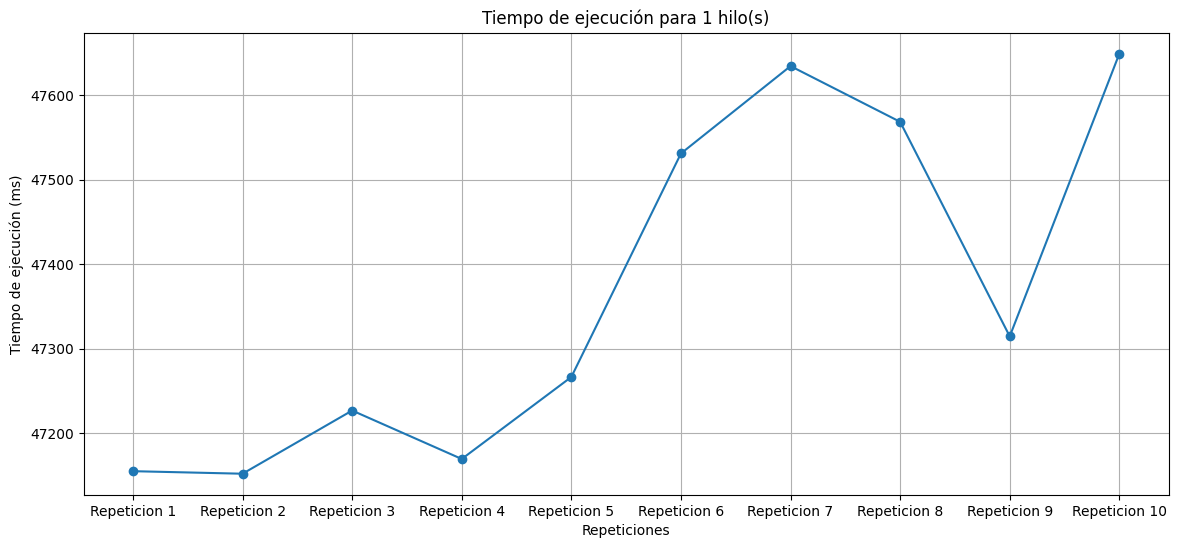

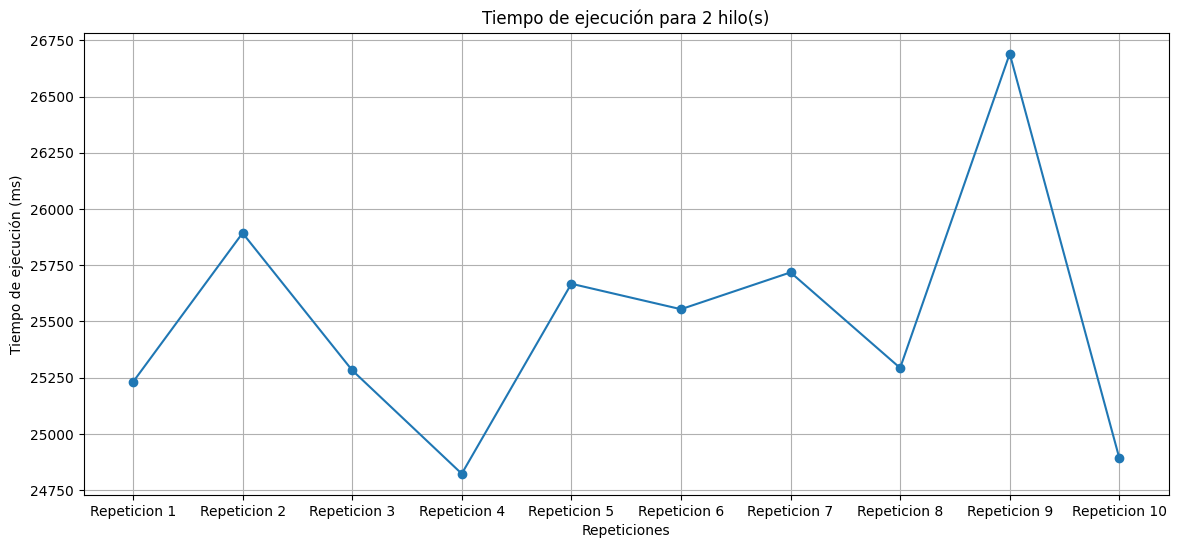

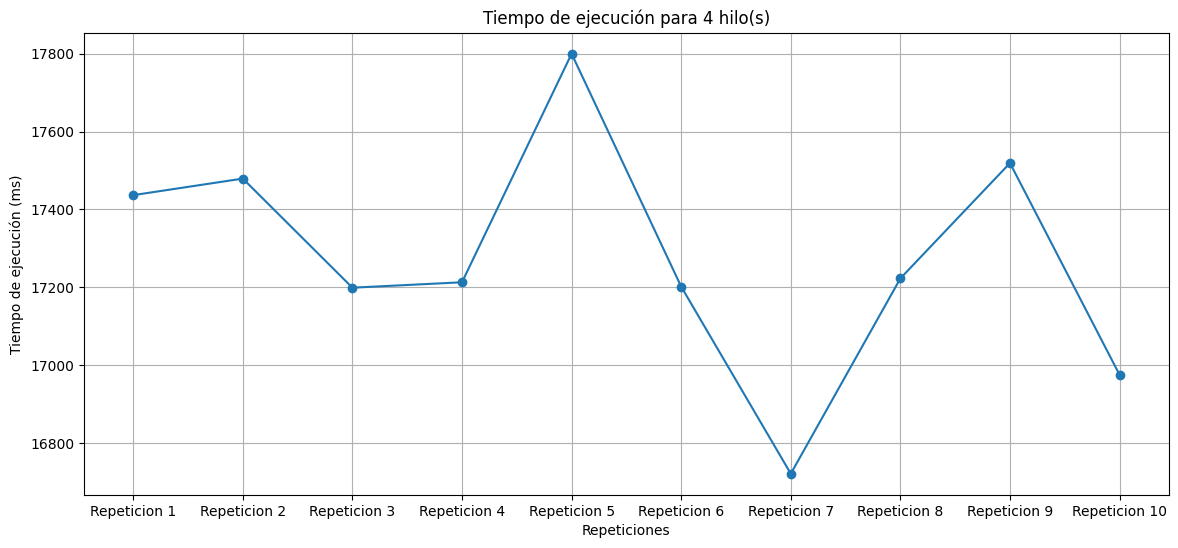

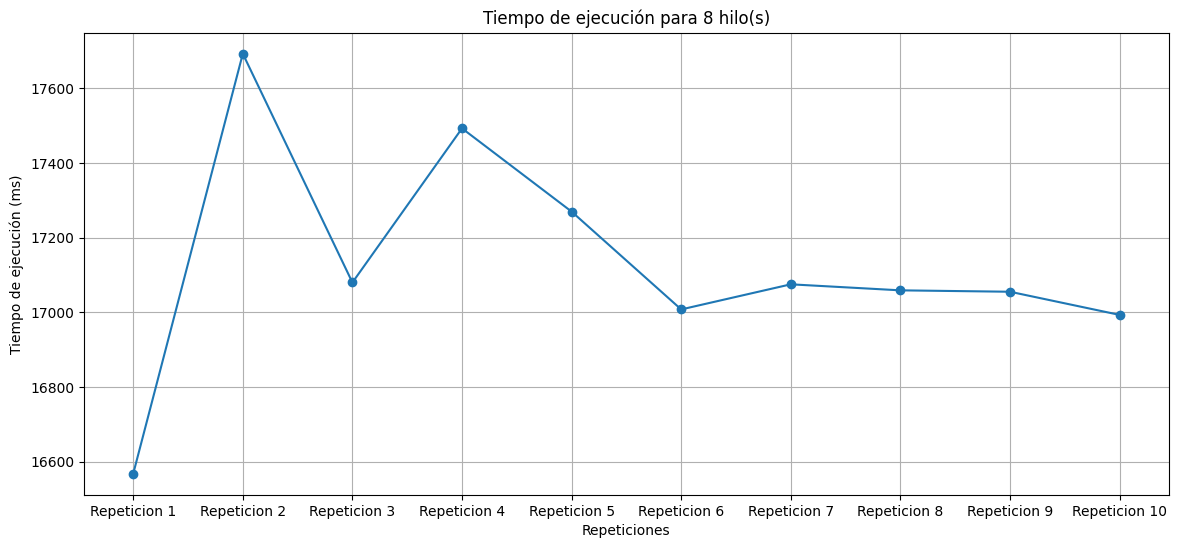

In [ ]:
import matplotlib.pyplot as plt

# Configuraciones de hilos
configuraciones_hilos = df_tiempos.index

# Iterar sobre cada configuración de hilos y crear un gráfico de líneas
for hilo in configuraciones_hilos:
    # Obtener los tiempos de ejecución para la configuración de hilos actual
    tiempos_ejecucion = df_tiempos.loc[hilo]

    # Crear el gráfico de líneas
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(tiempos_ejecucion)), tiempos_ejecucion, marker='o', linestyle='-')

    # Añadir etiquetas y título
    plt.xlabel('Repeticiones')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.title('Tiempo de ejecución para {} hilo(s)'.format(hilo))
    plt.xticks(range(len(tiempos_ejecucion)), ['Repeticion {}'.format(i) for i in range(1, 11)])
    plt.grid(True)

    # Mostrar el gráfico
    plt.show()



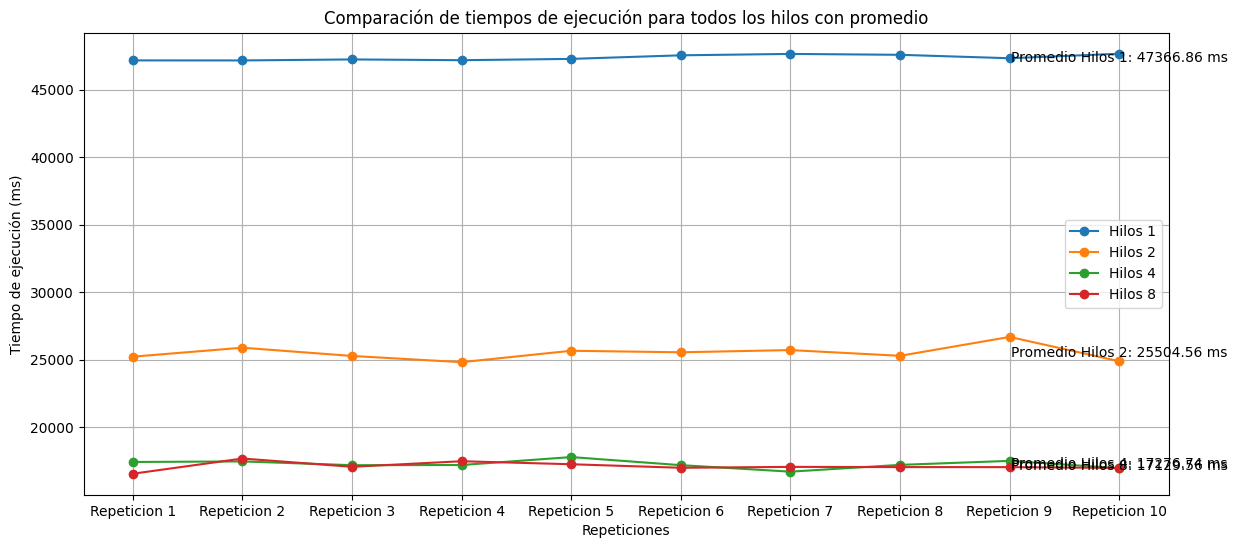

In [ ]:
import matplotlib.pyplot as plt

# Obtener los tiempos de ejecución para las configuraciones de hilos 4 y 8
tiempos_1 = df_tiempos.loc[1]
tiempos_2 = df_tiempos.loc[2]
tiempos_4 = df_tiempos.loc[4]
tiempos_8 = df_tiempos.loc[8]

# Calcular el promedio de los tiempos de ejecución para las configuraciones de hilos 4 y 8
promedio_1 = tiempos_1.mean()
promedio_2 = tiempos_2.mean()
promedio_4 = tiempos_4.mean()
promedio_8 = tiempos_8.mean()

# Crear el gráfico de líneas para las configuraciones de hilos 4 y 8 juntas
plt.figure(figsize=(14, 6))
plt.plot(range(len(tiempos_1)), tiempos_1, marker='o', linestyle='-', label='Hilos 1')
plt.plot(range(len(tiempos_2)), tiempos_2, marker='o', linestyle='-', label='Hilos 2')
plt.plot(range(len(tiempos_4)), tiempos_4, marker='o', linestyle='-', label='Hilos 4')
plt.plot(range(len(tiempos_8)), tiempos_8, marker='o', linestyle='-', label='Hilos 8')

# Mostrar el promedio como texto en el gráfico
plt.text(len(tiempos_1) - 1, promedio_1, 'Promedio Hilos 1: {:.2f} ms'.format(promedio_1), ha='center', va='center')
plt.text(len(tiempos_2) - 1, promedio_2, 'Promedio Hilos 2: {:.2f} ms'.format(promedio_2), ha='center', va='center')
plt.text(len(tiempos_4) - 1, promedio_4, 'Promedio Hilos 4: {:.2f} ms'.format(promedio_4), ha='center', va='center')
plt.text(len(tiempos_8) - 1, promedio_8, 'Promedio Hilos 8: {:.2f} ms'.format(promedio_8), ha='center', va='center')

# Añadir etiquetas y título
plt.xlabel('Repeticiones')
plt.ylabel('Tiempo de ejecución (ms)')
plt.title('Comparación de tiempos de ejecución para todos los hilos con promedio')
plt.xticks(range(len(tiempos_4)), ['Repeticion {}'.format(i) for i in range(1, 11)])
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()


## Conclusiones Generales

-En terminos generales, se puede ver una mejora significativa cada vez que se aumentan el numero de hilos par ejecutar el programa, lo cual significa que la paralelización del codigo se esta haciendo  de manera correcta y efectiva.

-Si bien no son cambios cuadráticos, el tiempo se reduce en gran medida (40% o 50%) cuando se cambia de 1 a 2 hilos en ejecución, de igual forma cuando pasan de 2 a 4 hilos.

-Para el caso de 4 y 8 hilos, los tiempos de ejecución son similares, no se puede ver una mejora significativa del tiempo de ejecución en el aumento de los hilos

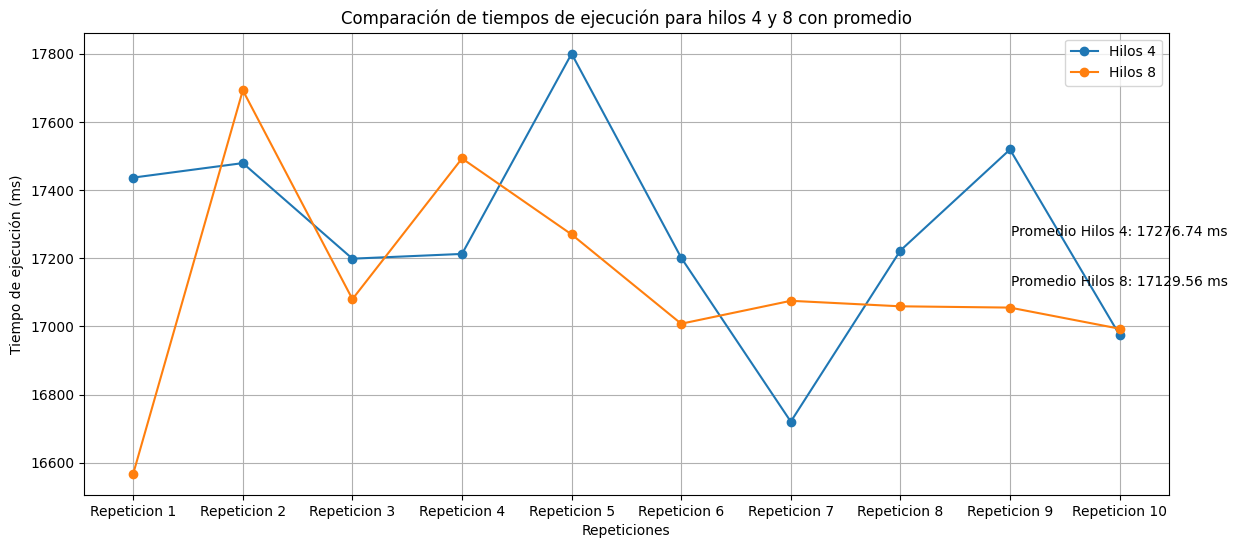

In [ ]:
import matplotlib.pyplot as plt

# Obtener los tiempos de ejecución para las configuraciones de hilos 4 y 8
tiempos_4 = df_tiempos.loc[4]
tiempos_8 = df_tiempos.loc[8]

# Calcular el promedio de los tiempos de ejecución para las configuraciones de hilos 4 y 8
promedio_4 = tiempos_4.mean()
promedio_8 = tiempos_8.mean()

# Crear el gráfico de líneas para las configuraciones de hilos 4 y 8 juntas
plt.figure(figsize=(14, 6))
plt.plot(range(len(tiempos_4)), tiempos_4, marker='o', linestyle='-', label='Hilos 4')
plt.plot(range(len(tiempos_8)), tiempos_8, marker='o', linestyle='-', label='Hilos 8')

# Mostrar el promedio como texto en el gráfico
plt.text(len(tiempos_4) - 1, promedio_4, 'Promedio Hilos 4: {:.2f} ms'.format(promedio_4), ha='center', va='center')
plt.text(len(tiempos_8) - 1, promedio_8, 'Promedio Hilos 8: {:.2f} ms'.format(promedio_8), ha='center', va='center')

# Añadir etiquetas y título
plt.xlabel('Repeticiones')
plt.ylabel('Tiempo de ejecución (ms)')
plt.title('Comparación de tiempos de ejecución para hilos 4 y 8 con promedio')
plt.xticks(range(len(tiempos_4)), ['Repeticion {}'.format(i) for i in range(1, 11)])
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()


## Conclusión respecto a 4 y 8 hilos

Referente a este caso, creemos que la razon por la que sucede esto, es que cuando se ejecuta el codigo con 4 hilos, lo hace de la manera mas optima posible, por lo que al aumentar el numero de hilos a 8, solo estamos malgastando recursos, ya que con la creacion y la union de estos hilos provoca que el tiempo de ejecucion sea casi igual al caso con 4 hilos.